# Simulations on the Pokec dataset (Section 4.3)

In [32]:
import pickle
import random
import numpy as np
import pandas as pd
import networkx as nx

import csv, datetime
from tqdm import tqdm
import itertools as iter

import string
import inspect
import copy, signal

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams

In [2]:
home_folder = './'

In [3]:
# Helper functions

debug = lambda str : f"print(\"{str}\",\"=\",eval(\"{str}\"))"

rcParams.update({
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
        'figure.figsize': (10,6),
})

def file_str():
    """ Auto-generates file name."""
    now = datetime.datetime.now()
    return now.strftime("H%HM%MS%S_%m-%d-%y")

rand_string = lambda length: ''.join(random.choice(string.ascii_lowercase) for i in range(length))

def pdf_savefig():
    """ Saves figures as pdf """
    fname = file_str()+rand_string(5)
    plt.savefig(home_folder+f"figs/{fname}.pdf")

def eps_savefig():
    """ Saves figure as encapsulated postscript file (vector format)
        so that it isn't pixelated when we put it into a pdf. """
    pdf_savefig()

## Load dataset and precompute

In [4]:
podecFolder = home_folder + './pokec-dataset/'

In [31]:
def readPodecData():
    G = nx.DiGraph() # directed graph object
    v = {} # a dictionary of vertices and their descriptions
    regions = {} # a dictionary with the regions
    n = 0 # number of vertices
    e = 0 # number of edges
    
    # add vertices
    file = podecFolder + f'soc-pokec-profiles.txt'
    with open(file, encoding='utf-8') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t')
        for r in tqdm(csv_reader): 
            n += 1
            
            # id
            r[0] = int(r[0], 10)  # id
            
            # gender
            if r[3] == 'null': r[3] = -1
            else: r[3] = 1 - int(r[3], 10)  # gender: 1 -- female, 0 -- male 
            
            # age 
            if r[7] == 'null' or r[7] == '0': r[7] = -1
            else: r[7] = int(r[7])
            
            # regions (update the dictionary)
            if r[4] not in regions: regions[r[4]] = 1
            
            # add node description
            v[r[0]] = {'id': r[0],\
                       'public': r[1],\
                       'gender': r[3],\
                       'age': r[7],\
                       'body': r[8],\
                       'language': r[10],\
                       'last-login': r[5],\
                       'registration': r[6],\
                       'region': r[4]}
    
    # add nodes with their descriptions
    G.add_nodes_from([(u, v[u]) for u in v])
    
    file = podecFolder + f'soc-pokec-relationships.txt'
    with open(file, encoding='utf-8') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t')
        for r in csv_reader:
            
            r[0] = int(r[0], 10)
            r[1] = int(r[1], 10)
            
            G.add_edge(r[0], r[1]) # add an edge
            
            e += 1
            if e % 100000 == 0: print(e, flush=True)
    
    print(f'Tot edges: {e}, tot nodes: {n}.')
    return G, regions

In [6]:
G, _ = readPodecData()

1632803it [00:36, 44356.46it/s]


100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000
1

### Compute eigenvector centrality

In [8]:
# This takes a some time to compute.
# To avoid this computation, we provide a copy of the result as a picked file 
# However, the user is welcome to flip the flag below to compute the result 
doCompute = False
if doCompute:
    evCen = nx.eigenvector_centrality(G)
    file = open(home_folder + 'evCen'+file_str()+rand_string(5), 'wb')
    pickle.dump(evCen, file)
    
# Load picked result
file = open(home_folder + 'evCen_pnatl', 'rb')
evCen = pickle.load(file)

## Intra-network vs non-network fairness metrics (Section 4.3.2)

### Helper functions

In [9]:
def getOutcomeMeasure(G, netM, mnDg=-1):
    # G: DiGraph (networkx format)
    # netM: a node-level network measure
    # mnDg: minimum inDegree required
    
    # check if gender known
    def ok(i): return (G.nodes[i]['gender'] != -1)

    grpSz = np.array([0.0,0.0]) # male, female
    
    # Save a reversed copy for use later.
    # `copy = False` ensures that the graph isn't copied. 
    # This is especially important as the graph takes a lot of memory.
    revG = G.reverse(copy=False)
    
    inDeg = {} # precompute in degree to speed up things (random accesses to G take time)
    for i in G.nodes(): inDeg[i] = revG.out_degree(i)
    
    # compute group sizes
    for i in G.nodes: 
        if not ok(i): continue
        if G.nodes[i]['gender'] == 1: grpSz[1] += 1
        if G.nodes[i]['gender'] == 0: grpSz[0] += 1
    
    ## results without network measures and with network measures (respectively)
    sumNoNet = np.array([0.0, 0.0])
    sumNet = np.array([0.0, 0.0]) # description: [male_cnt, female_cnt]

    ## main computation
    for i in G.nodes:
        u = G.nodes[i]
        
        if inDeg[i] >= mnDg: 
            if not ok(i): continue
            sumNoNet[u['gender']] += 1 # update non-network outcome measure
            sumNet[u['gender']] += netM[i] # update network outcome measure

    return sumNet[0] / (sumNet[0] + sumNet[1] + 1e-15), sumNoNet[0] / (sumNoNet[0] + sumNoNet[1] + 1e-15)

In [10]:
def getListOfOutcomes(evCenInput):
    rateNoNets = []
    rateNets = [] 

    for mnDg in tqdm(r):
        srNet, srNoNet = getOutcomeMeasure(G, evCenInput, mnDg)
        
        rateNets.append(srNet)
        rateNoNets.append(srNoNet)

    return rateNets, rateNoNets

In [11]:
def plotFig1(rateNets, rateNoNets, title=""):
    fig, ax = plt.subplots()
    plt.plot(x, rateNets, '--', label='Eigenvalue centrality', linewidth=4, alpha=1.0)
    plt.plot(x, rateNoNets, '--', label='Non-network measure', linewidth=4, alpha=1.0)
    plt.plot(x, [rateNoNets[0]]*len(x), label='Proportion of Men', color='black', linewidth=4)

    ## Decorate
    plt.ylim(0,1)
    ax.set_xscale('log')
    plt.gca().invert_xaxis()

    plt.ylabel('Ratio: $\\frac{w(G_{\\rm male})} { w(G_{\\rm male}) + w(G_{\\rm female})} $', fontsize=25)
    plt.xlabel('$\\alpha$',fontsize=25)
    legend = plt.legend(loc='best', shadow=False, fontsize=15)
    
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.title(f'Ratio of specificed metric on the $x$% of users with the highest in-degree\n'+title, fontsize=15)
    pdf_savefig()

### Compute things

In [12]:
## lower bound on the in-degree
r = np.array(list(np.linspace(0,473,25))\
              + list(np.linspace(500,2000,25))\
              + list(np.linspace(2000,10000,25)))

## compute the number of nodes with in-degree higher than r[i]
x = np.array([0] * len(r))
for i in tqdm(G.nodes):
    inDeg = G.in_degree(i)
    for j in range(len(r)):
        if inDeg >= r[j]: x[j] += 1

## convert the above counts to fractions
x = x/len(G.nodes)

100%|██████████| 1632803/1632803 [01:28<00:00, 18411.18it/s]


In [29]:
rateNets, rateNoNets = getListOfOutcomes(evCen)

100%|██████████| 75/75 [14:15<00:00, 11.40s/it]


### Plot

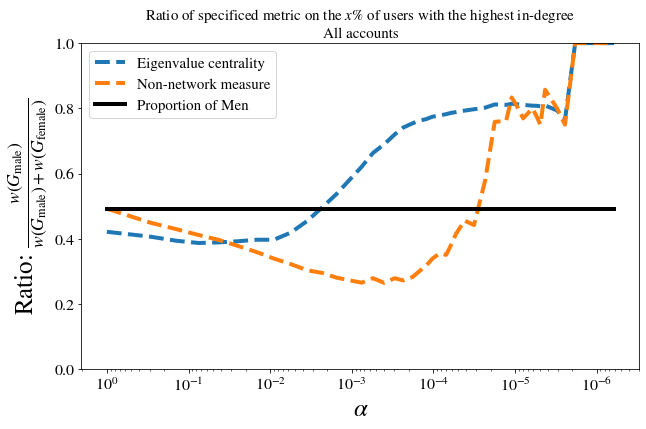

In [33]:
plotFig1(rateNets, rateNoNets, 'All accounts')

## Inter-group vs Intra-network fairness metrics (Section 4.3.3)

### Helper functions

In [92]:
computeBMI = lambda w, h: w / h**2 * 100*100

In [93]:
def parseWtAndHt(chkAge = False, threshAge = 20):    
    wtHtPublic = 0
    wts = {}
    hts = {}
    
    c=0; d=0; e=0;

    for i in tqdm(G.nodes):
        if G.nodes[i]['body'] != 'null' and G.nodes[i]['gender'] != -1: 
            if chkAge:
                if G.nodes[i]['age'] == -1 or G.nodes[i]['age'] < threshAge: continue
            
            wtHtPublic += 1
            st = G.nodes[i]['body'] # string describing weight and height from the profile
            li = st.split(',') # weight, height, and description are comma separated

            if len(li) < 2: continue # either weight or height or both missing

            ht = li[0] # height first, then weight
            wt = li[1]

            if len(ht.split(' ')) < 2: continue # height is a number + space + 'cm' 
            if len(wt.split(' ')) < 2: continue # weight is a number + space + 'kg'

            c+=1

            if ht.split(' ')[-1] != 'cm': continue # if unit is incorrect then skip
            if wt.split(' ')[-1] != 'kg': continue # if unit is incorrect then skip

            d+=1

            try:
                tmpH = int(ht.replace(" ", "")[:-2], 10) # convert to integer, if fails skip
                tmpW = int(wt.replace(" ", "")[:-2], 10) # convert to integer, if fails skip
            except: 
                e+=1
                continue
            
            # skip unresonable values (we think the users could enter any value they wished)
            if tmpH <= 1 and tmpH >= 1000: continue
            if tmpW <= 1 and tmpW >= 1000: continue

            hts[i] = tmpH
            wts[i] = tmpW

    st = f' AND age >= {threshAge}: ' if chkAge else ''
    print(f'ht/wt public is non-empty' + st)
    print(f'Fraction of total: {wtHtPublic / len(G.nodes)}')
    print(f'Count: {wtHtPublic}')
    print('')
    
    print(f'ht/wt public is-parsable' + st)
    print(f'Fraction of total: {len(list(wts.keys())) / len(G.nodes)}')
    print(f'Count: {len(list(wts.keys()))}')
    print('')
    
    # print('Counts lost at each step:')
    # eval(debug('c,d,e'))
    
    return wts, hts

### Compute BMIs

In [94]:
wts, hts = parseWtAndHt(False, -1)

100%|██████████| 1632803/1632803 [00:06<00:00, 255824.26it/s]

ht/wt public is non-empty
Fraction of total: 0.4861860248909391
Count: 793846

ht/wt public is-parsable
Fraction of total: 0.3738466918544368
Count: 610418



### Helper functions

In [95]:
def getWeightnHeight(i, chkAge=False):
    st = G.nodes[i]['body'] # string describing weight and height from the profile

    if chkAge:
        if G.nodes[i]['age'] == -1 or G.nodes[i]['age'] < 20: return -1, -1
    
    li = st.split(',') # weight, height, and description are comma separated
    if len(li) < 2: return -1, -1 # either weight or height or both missing
    ht = li[0] # height first, then weight
    wt = li[1] 
    
    if len(ht.split(' ')) < 2: return -1, -1 # height is a number + space + 'cm' 
    if len(wt.split(' ')) < 2: return -1, -1 # weight is a number + space + 'kg'
        
    if ht.split(' ')[-1] != 'cm': return -1, -1 # if unit is incorrect then skip
    if wt.split(' ')[-1] != 'kg': return -1, -1 # if unit is incorrect then skip

    try: 
        tmpH = int(ht.replace(" ", "")[:-2], 10) # convert to integer, if fails skip
        tmpW = int(wt.replace(" ", "")[:-2], 10) # convert to integer, if fails skip
    except: return -1, -1
    
    # skip unresonable values (we think the users could enter any value they wished)
    if tmpH >= 1000 or tmpH <= 1: return -1, -1 # skip unresonable values
    if tmpW >= 1000 or tmpW <= 1: return -1, -1 # skip unresonable values
    
    return tmpW, tmpH

In [96]:
def getBMI(i, chkAge=False):
    w, h = getWeightnHeight(i, chkAge)
    
    if w == -1 or h == -1: return -1
    
    return computeBMI(w, h)

In [97]:
def getBin(bmi, g):
    if bmi == -1 or g == -1: return -1
    if bmi <= 30 and g == 0: return 0
    if bmi <= 30 and g == 1: return 1
    if bmi > 30 and g == 0: return 2
    if bmi > 30 and g == 1: return 3
    return -1

In [98]:
def computeSum(sumNetOri, G, revG, grpSz, binIs):
    # computes the number of edges between each pair of groups
    
    sz = len(sumNetOri[0])
    for i in tqdm(G.nodes):
        if binIs[i] == -1: continue
        for j in revG[i]:
            if binIs[j] == -1: continue
            
            # count an edge
            sumNetOri[ binIs[i] ][ binIs[j] ] += 1

    sumNetNor = copy.deepcopy(sumNetOri)

    # sumNetNor[a][b] edges from 'a'<-'b'
    # normalize by product of group sizes
    for l, l2 in iter.product(range(sz), range(sz)): 
        sumNetNor[l][l2] /= grpSz[l] * grpSz[l2]

    return sumNetNor, sumNetOri

In [99]:
def getInteractionMeasure(G, chkAge=False):

    # create zero
    def initializeZeroSum(): return np.zeros((4,4))
    
    # get the protected group (aka bin) of each node
    binIs = {}
    for i in tqdm(G.nodes): binIs[i] = getBin(getBMI(i, chkAge=chkAge), G.nodes[i]['gender'])
    print("Done with computing binIs.")
    
    # number of people in each group
    grpSz = {}
    for i in range(4): grpSz[i] = 0.0

    cnt = 0
    for i in tqdm(G.nodes): 
        b = binIs[i]
        if b != -1: grpSz[b] += 1     
        else: cnt += 1

    print('Group sizes are:', grpSz)
    
    # Save a reversed copy for use later.
    # `copy = False` ensures that the graph isn't copied. 
    # This is especially important as the graph takes a lot of memory.
    revG = G.reverse(copy=False)
    sumNetOri = initializeZeroSum()
        
    # computes the actual interaction measure
    sumNetNor, sumNetOri = computeSum(sumNetOri, G, revG, grpSz, binIs)    
    
    return sumNetNor, sumNetOri, grpSz

### Run simulation 

In [100]:
sumNetNor, sumNetOri, grpSzWt = getInteractionMeasure(G, chkAge=False)

 14%|█▎        | 220935/1632803 [00:00<00:00, 2209178.29it/s]

Done with computing binIs.


  0%|          | 4774/1632803 [00:00<00:34, 47726.05it/s]

Group sizes are: {0: 330148.0, 1: 256404.0, 2: 14829.0, 3: 4880.0}


100%|██████████| 1632803/1632803 [00:18<00:00, 86975.66it/s] 


### Print and store things

TODO:
1. add code to store these in file for chord diagram
2. add code to compute statistical rate  

In [101]:
##
sep = '\t'


grpSzWtLi = list(grpSzWt.values())

cat = ['', 'N-O M', 'N-O W', 'O M', 'O W']

############################################################################
## Intersectional
############################################################################
print('\nIntersectional setting')
print('='*50)
for i in cat: print(f'{i}', end=sep)
print('')
for i in range(4):
    print(cat[i+1], end=sep)
    li = list(sumNetOri.T[i])
    # print(np.sum(li))
    sm = 0
    for j in range(4): print(round(sumNetNor[j][i] * 1e5, 2), end=sep)
    print('')
print('')


print('')
print('Statistical rate by in-degree')
mn, mx = 1e8, -1
for i, ty in enumerate(cat[1:]): 
    type1 = np.sum(sumNetOri[i])/grpSzWtLi[i]
    type2 = np.min(sumNetNor[i])/np.max(sumNetNor[i])
    mx = max(mx, type1)
    mn = min(mn, type1)
    print(f'{ty}\tSR:{np.round(type2, 3)}\tType1 avg-in: {round(type1, 1)}')

print(f'Type 1 statistical rate: {round(mn/mx,2)}')    
    
    
print('')
print('')
print('\nNon-intersectional setting')
print('='*50)
############################################################################
## Gender
############################################################################

print('\nProtected attribute: Gender')
print('-'*50)
sumOriGen = np.zeros((2,2)) # male, female
sumNorGen = np.zeros((2,2)) # male, female
grpSzGen = [0,0]
for i, j in iter.product(range(2), range(2)):
    sumOriGen[i][j] = sumNetOri[i+0][j+0] + sumNetOri[i+0][j+2] + sumNetOri[i+0][j+2] + sumNetOri[i+2][j+2]
    grpSzGen[i] =  grpSzWtLi[i] + grpSzWtLi[i+2]

for i, j in iter.product(range(2), range(2)): sumNorGen[i][j] = sumOriGen[i][j] / (grpSzGen[i] * grpSzGen[j])


    
print('Results for gender by in-degree')
mn, mx = 1e8, -1
for i, ty in enumerate(['m', 'f']): 
    type2 = np.min(sumNorGen[i])/np.max(sumNorGen[i])
    type1 = np.sum(sumOriGen[i])/grpSzGen[i]
    mx = max(mx, type1)
    mn = min(mn, type1)
    print(f'{ty}\tSR:{round(type2, 3)}\tType1 avg-in: {round(type1, 1)}', end='\n')

print(f'Type 1 statistical rate: {round(mn/mx,2)}')

print('')
print('\nProtected attribute: BMI')
print('-'*50)
############################################################################
## BMI
############################################################################
sumOriBMI = np.zeros((2,2)) # male, female
sumNorBMI = np.zeros((2,2)) # male, female
grpSzBMI = [0,0]
for i, j in iter.product(range(2), range(2)):
    sumOriBMI[i][j] = sumNetOri[2*i+0][2*j+0] + sumNetOri[2*i+0][2*j+1] + sumNetOri[2*i+0][2*j+1] + sumNetOri[2*i+1][2*j+1]
    grpSzBMI[i] =  grpSzWtLi[2*i] + grpSzWtLi[2*i+1]

for i, j in iter.product(range(2), range(2)): sumNorBMI[i][j] = sumOriBMI[i][j] / (grpSzBMI[i] * grpSzBMI[j])
    
print('')
print('Results for BMI by in-degree')
mn, mx = 1e8, -1
for i, ty in enumerate(['n-obese', 'obese']): 
    type1 = np.sum(sumOriBMI[i])/grpSzBMI[i]
    type2 = np.min(sumNorBMI[i])/np.max(sumNorBMI[i])
    mx = max(mx, type1)
    mn = min(mn, type1)
    print(f'{ty}\tSR type2:{round(type2, 3)}\tType1 avg-in: {round(type1, 1)}', end='\n')
print(f'Type 1 statistical rate: {round(mn/mx,2)}')


Intersectional setting
	N-O M	N-O W	O M	O W	
N-O M	1.52	2.04	1.22	1.67	
N-O W	1.8	1.5	1.44	1.3	
O M	1.2	1.69	1.82	2.14	
O W	1.5	1.39	1.94	3.33	


Statistical rate by in-degree
N-O M	SR:0.67	Type1 avg-in: 9.9
N-O W	SR:0.681	Type1 avg-in: 10.9
O M	SR:0.628	Type1 avg-in: 8.1
O W	SR:0.39	Type1 avg-in: 9.3
Type 1 statistical rate: 0.74



Non-intersectional setting

Protected attribute: Gender
--------------------------------------------------
Results for gender by in-degree
m	SR:0.855	Type1 avg-in: 9.7
f	SR:0.729	Type1 avg-in: 11.0
Type 1 statistical rate: 0.88


Protected attribute: BMI
--------------------------------------------------

Results for BMI by in-degree
n-obese	SR type2:0.653	Type1 avg-in: 9.9
obese	SR type2:0.82	Type1 avg-in: 9.8
Type 1 statistical rate: 0.99


### Run simulation (only for users with age ≥ 20)

In [102]:
wts, hts = parseWtAndHt(True, 20)

100%|██████████| 1632803/1632803 [00:05<00:00, 272401.09it/s]

ht/wt public is non-empty AND age >= 20: 
Fraction of total: 0.24021881390467803
Count: 392230

ht/wt public is-parsable AND age >= 20: 
Fraction of total: 0.1910377430712707
Count: 311927



In [103]:
sumNetNor, sumNetOri, grpSzWt = getInteractionMeasure(G, chkAge=True)

 13%|█▎        | 217510/1632803 [00:00<00:00, 2174920.58it/s]

Done with computing binIs.


  1%|          | 9539/1632803 [00:00<00:17, 95377.81it/s]

Group sizes are: {0: 179556.0, 1: 119812.0, 2: 9124.0, 3: 2388.0}


100%|██████████| 1632803/1632803 [00:07<00:00, 206559.71it/s]


### Print and store things

In [104]:
##
sep = '\t'


grpSzWtLi = list(grpSzWt.values())

cat = ['', 'N-O M', 'N-O W', 'O M', 'O W']

############################################################################
## Intersectional
############################################################################
print('\nIntersectional setting')
print('='*50)
for i in cat: print(f'{i}', end=sep)
print('')
for i in range(4):
    print(cat[i+1], end=sep)
    li = list(sumNetOri.T[i])
    # print(np.sum(li))
    sm = 0
    for j in range(4): print(round(sumNetNor[j][i] * 1e5, 2), end=sep)
    print('')
print('')


print('')
print('Statistical rate by in-degree')
mn, mx = 1e8, -1
for i, ty in enumerate(cat[1:]): 
    type1 = np.sum(sumNetOri[i])/grpSzWtLi[i]
    type2 = np.min(sumNetNor[i])/np.max(sumNetNor[i])
    mx = max(mx, type1)
    mn = min(mn, type1)
    print(f'{ty}\tSR:{np.round(type2, 3)}\tType1 avg-in: {round(type1, 1)}')

print(f'Type 1 statistical rate: {round(mn/mx,2)}')    
    
    
print('')
print('')
print('\nNon-intersectional setting')
print('='*50)
############################################################################
## Gender
############################################################################

print('\nProtected attribute: Gender')
print('-'*50)
sumOriGen = np.zeros((2,2)) # male, female
sumNorGen = np.zeros((2,2)) # male, female
grpSzGen = [0,0]
for i, j in iter.product(range(2), range(2)):
    sumOriGen[i][j] = sumNetOri[i+0][j+0] + sumNetOri[i+0][j+2] + sumNetOri[i+0][j+2] + sumNetOri[i+2][j+2]
    grpSzGen[i] =  grpSzWtLi[i] + grpSzWtLi[i+2]

for i, j in iter.product(range(2), range(2)): sumNorGen[i][j] = sumOriGen[i][j] / (grpSzGen[i] * grpSzGen[j])


    
print('Results for gender by in-degree')
mn, mx = 1e8, -1
for i, ty in enumerate(['m', 'f']): 
    type2 = np.min(sumNorGen[i])/np.max(sumNorGen[i])
    type1 = np.sum(sumOriGen[i])/grpSzGen[i]
    mx = max(mx, type1)
    mn = min(mn, type1)
    print(f'{ty}\tSR:{round(type2, 3)}\tType1 avg-in: {round(type1, 1)}', end='\n')

print(f'Type 1 statistical rate: {round(mn/mx,2)}')

print('')
print('\nProtected attribute: BMI')
print('-'*50)
############################################################################
## BMI
############################################################################
sumOriBMI = np.zeros((2,2)) # male, female
sumNorBMI = np.zeros((2,2)) # male, female
grpSzBMI = [0,0]
for i, j in iter.product(range(2), range(2)):
    sumOriBMI[i][j] = sumNetOri[2*i+0][2*j+0] + sumNetOri[2*i+0][2*j+1] + sumNetOri[2*i+0][2*j+1] + sumNetOri[2*i+1][2*j+1]
    grpSzBMI[i] =  grpSzWtLi[2*i] + grpSzWtLi[2*i+1]

for i, j in iter.product(range(2), range(2)): sumNorBMI[i][j] = sumOriBMI[i][j] / (grpSzBMI[i] * grpSzBMI[j])
    
print('')
print('Results for BMI by in-degree')
mn, mx = 1e8, -1
for i, ty in enumerate(['n-obese', 'obese']): 
    type1 = np.sum(sumOriBMI[i])/grpSzBMI[i]
    type2 = np.min(sumNorBMI[i])/np.max(sumNorBMI[i])
    mx = max(mx, type1)
    mn = min(mn, type1)
    print(f'{ty}\tSR type2:{round(type2, 3)}\tType1 avg-in: {round(type1, 1)}', end='\n')
print(f'Type 1 statistical rate: {round(mn/mx,2)}')


Intersectional setting
	N-O M	N-O W	O M	O W	
N-O M	1.77	2.55	1.33	1.97	
N-O W	2.16	1.73	1.77	1.4	
O M	1.32	2.11	1.83	2.61	
O W	1.72	1.47	2.34	3.05	


Statistical rate by in-degree
N-O M	SR:0.611	Type1 avg-in: 5.9
N-O W	SR:0.575	Type1 avg-in: 6.9
O M	SR:0.569	Type1 avg-in: 4.7
O W	SR:0.459	Type1 avg-in: 5.5
Type 1 statistical rate: 0.69



Non-intersectional setting

Protected attribute: Gender
--------------------------------------------------
Results for gender by in-degree
m	SR:0.829	Type1 avg-in: 5.8
f	SR:0.666	Type1 avg-in: 7.0
Type 1 statistical rate: 0.83


Protected attribute: BMI
--------------------------------------------------

Results for BMI by in-degree
n-obese	SR type2:0.604	Type1 avg-in: 6.0
obese	SR type2:0.912	Type1 avg-in: 5.8
Type 1 statistical rate: 0.98
